In [1]:
import lab
import gpflow as gp
import math
import scipy.fft
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn
import json

import sys, importlib, pathlib
sys.path.insert(0, str(pathlib.Path().resolve().parent))

seaborn.set()
seaborn.set_style('whitegrid') # use whitegrid for print-ready plots

lab.default_dtype=np.float64

import vff
plt.rcParams.update({'figure.figsize' : (8, 6),
                     # bigger labels for readability
                    'font.size' : 22,
                    'axes.labelsize' : 28,
                    'xtick.labelsize' : 22,
                    'ytick.labelsize' : 22,
                     'axes.titlesize' : 28,
                     # Latex-like fonts
                     'text.usetex' : True,
                     'font.family' : 'serif',
                     'font.serif' : 'Computer Modern',
                     'mathtext.fontset' : 'cm',
                     'mathtext.rm' : 'Bitstream Vera Sans',
                     'mathtext.it' : 'Bitstream Vera Sans:italic',
                     'mathtext.bf' : 'Bitstream Ver Sans:bold',
                      'lines.linewidth' : 3,
                    })



2023-08-20 15:44:37.819674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 15:44:38.380804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-20 15:44:38.380882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-20 15:44:38.380888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [42]:
lab.set_random_seed(7)

N = 1000
#L = 1.
# OR
L = 0.5
sigma_f = 0.1*lab.exp(lab.squeeze(lab.randn(1)))
width = math.sqrt(N/2)/L
#snr = 2*lab.exp(lab.randn(1))
# OR
#snr = lab.exp(lab.randn(1))
# OR
snr = 2*lab.exp(lab.randn(1))
print(sigma_f, snr)

0.5422330495741096 [1.25509317]


In [35]:
import tensorflow as tf
from tqdm.notebook import tqdm

tf.config.run_functions_eagerly(True) 
lab.set_random_seed(7)

N = 1000
#L = 1.
# OR
L = 0.5
sigma_f = 0.1*lab.exp(lab.squeeze(lab.randn(1)))
width = math.sqrt(N/2)/L
#snr = 2*lab.exp(lab.randn(1))
# OR
#snr = lab.exp(lab.randn(1))
# OR
snr = 8*lab.exp(lab.randn(1))
#x = 6*width*lab.rand(N) -3*width
x = lab.randn(N)*width
gt_kernel = gp.kernels.SquaredExponential()
gt_lik = gp.likelihoods.Gaussian()
gt_kernel.variance.assign(sigma_f)
gt_lik.variance.assign(lab.squeeze(gt_kernel.variance / snr))
gt_kernel.lengthscales.assign(lab.squeeze(L))
K = gt_kernel.K(lab.expand_dims(x, axis=-1), lab.expand_dims(x, axis=-1)) + gt_lik.variance * lab.eye(x.dtype, N)
y = lab.squeeze(lab.mm(lab.chol(K), lab.randn(N, 1)), axis=-1)

num_bw = 15
num_bwx = 30
bw_freq = np.linspace(0.4, 1.8, num_bw)
eps_bw_x = np.linspace(0.1, 1.5, num_bwx)
xx, yy = np.meshgrid(bw_freq, eps_bw_x)
op = lab.zeros(np.float64, num_bw, num_bwx)
for i in tqdm(range(num_bw)):
    for j in tqdm(range(num_bwx)):
        eps = eps_bw_x[j]/(6*width)
        M = int(bw_freq[i]/(L*eps))
        if M % 2 == 1:
            M = M + 1
        u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, M//2)]
        )
        model = vff.sgpr.SGPR(
            data = (lab.expand_dims(x, axis=-1), lab.expand_dims(y, axis=-1)),
            kernel = gt_kernel,
            noise_variance = gt_lik.variance,
            inducing_variable = u,
    )

        op[i, j] = (vff.objectives.log_marginal_likelihood(y, lab.expand_dims(x, axis=-1), gt_kernel, gt_lik)/N 
                    - model.elbo()/N
                   )
        #op[i, j] = lab.to_numpy(bound)

tf.config.run_functions_eagerly(False) 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

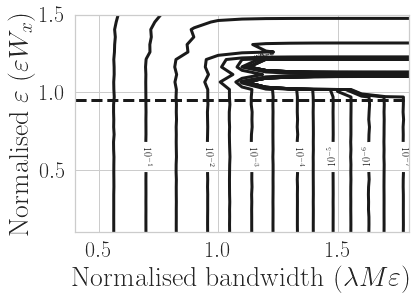

In [36]:
cs = plt.contour(xx, yy, lab.t(op), levels=[1e-7, 3.16e-7, 1e-6, 3.16e-6, 1e-5, 3.16e-5, 1e-4, 3.16e-4, 1e-3, 3.16e-3, 1e-2, 
                                       3.16e-2, 1e-1, 3.16e-1, 1], 
                 colors='k')
fmt = {}
strs = [r'$10^{-7}$', r'$\sqrt{10}10^{-7}$',
       r'$10^{-6}$', r'$\sqrt{10}10^{-6}$',
       r'$10^{-5}$', r'$\sqrt{10}10^{-5}$',
       r'$10^{-4}$', r'$\sqrt{10}10^{-4}$',
       r'$10^{-3}$', r'$\sqrt{10}10^{-3}$',
       r'$10^{-2}$', r'$\sqrt{10}10^{-2}$',
       r'$10^{-1}$',  r'$\sqrt{10}10^{-1}$',
       r'$10^{0}$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

# Label every other level using strings
txt = plt.clabel(cs, cs.levels[::2], fmt=fmt)

# enforce consistent rotation

#for t in txt:
#    t.set_rotation(270)
    
plt.xlabel(r'Normalised bandwidth ($\lambda M \varepsilon$)')
plt.ylabel(r'Normalised $\varepsilon$ ($\varepsilon W_{x}$)')
plt.plot(bw_freq, [0.95 for u in bw_freq], 'k--')
#plt.savefig('../images/contour_gaussian_snr_{:.3f}_L_{:.3f}.png'.format(snr[0], L[0]), bbox_inches="tight")

In [37]:
tf.config.run_functions_eagerly(True) 
gt_kernel2 = gp.kernels.Matern32()
gt_kernel.variance.assign(sigma_f)
gt_kernel.lengthscales.assign(lab.squeeze(L))
K = gt_kernel2.K(lab.expand_dims(x, axis=-1), lab.expand_dims(x, axis=-1)) + gt_lik.variance * lab.eye(x.dtype, N)
y = lab.squeeze(lab.mm(lab.chol(K), lab.randn(N, 1)), axis=-1)

num_bw = 15
num_bwx = 30
bw_freq2 = np.linspace(1.0, 2.8, num_bw)
eps_bw_x2 = np.linspace(0.1, 1.5, num_bwx)
xx2, yy2 = np.meshgrid(bw_freq2, eps_bw_x2)
op2 = lab.zeros(np.float64, num_bw, num_bwx)
for i in tqdm(range(num_bw)):
    for j in tqdm(range(num_bwx)):
        eps = eps_bw_x2[j]/(6*width)
        M = int(bw_freq2[i]/(L*eps))
        if M % 2 == 1:
            M = M + 1
        u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, M//2)]
        )
        model = vff.sgpr.SGPR(
            data = (lab.expand_dims(x, axis=-1), lab.expand_dims(y, axis=-1)),
            kernel = gt_kernel2,
            noise_variance = gt_lik.variance,
            inducing_variable = u,
    )

        op2[i, j] = (vff.objectives.log_marginal_likelihood(y, lab.expand_dims(x, axis=-1), gt_kernel2, gt_lik)/N 
                    - model.elbo()/N
                   )
        #op[i, j] = lab.to_numpy(bound)

tf.config.run_functions_eagerly(False) 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

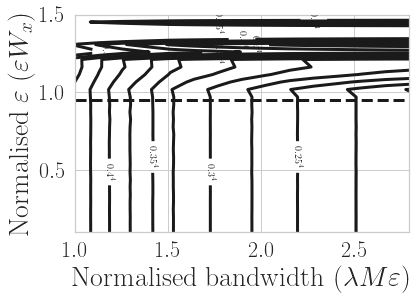

In [38]:
proto = [0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
levels = [x**(4) for x in proto]

cs = plt.contour(xx2, yy2, lab.t(op2), levels=levels, 
                 colors='k')
fmt = {}
strs = [r'${}^4$'.format(lev) for lev in proto]
for l, s in zip(cs.levels, strs):
    fmt[l] = s
    


# Label every other level using strings
txt = plt.clabel(cs, cs.levels[::2], fmt=fmt)

# enforce consistent rotation

for t in txt:
    t.set_rotation(270)
    
plt.xlabel(r'Normalised bandwidth ($\lambda M \varepsilon$)')
plt.ylabel(r'Normalised $\varepsilon$ ($\varepsilon W_{x}$)')

plt.plot(bw_freq2, [0.95 for u in bw_freq2], 'k--')
#plt.savefig('../images/contour_gaussian_snr_{:.3f}_L_{:.3f}.png'.format(snr[0], L[0]), bbox_inches="tight")

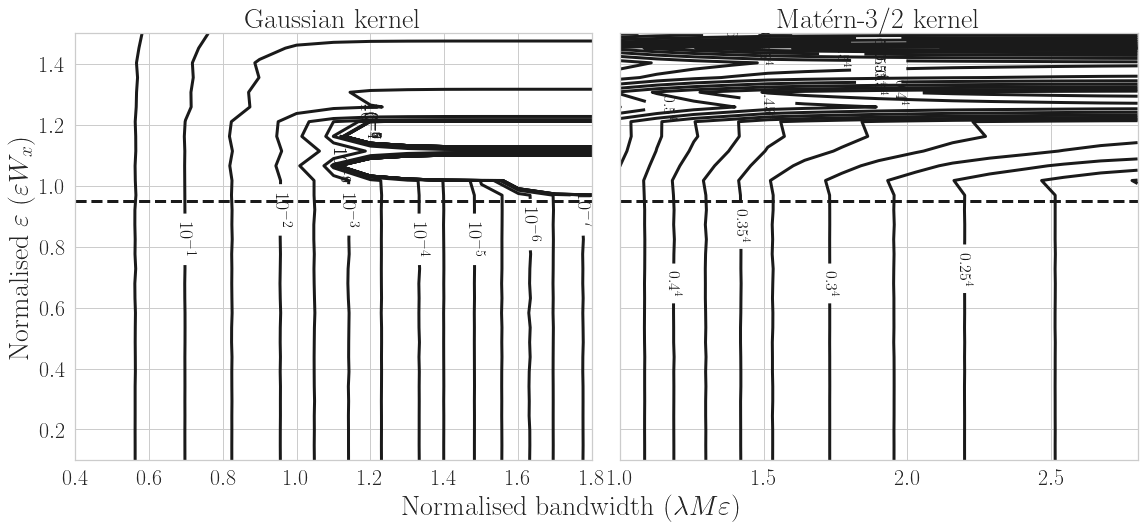

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
cs = axs[0].contour(xx, yy, lab.t(op), levels=[1e-9, 3.16e-9, 1e-8, 3.16e-8, 1e-7, 3.16e-7, 1e-6, 3.16e-6, 1e-5, 3.16e-5, 1e-4, 3.16e-4, 1e-3, 3.16e-3, 1e-2, 
                                       3.16e-2, 1e-1, 3.16e-1, 1], 
                 colors='k',)
fmt = {}
strs = [r'$10^{-9}$', r'$\sqrt{10}10^{-9}$',
    r'$10^{-8}$', r'$\sqrt{10}10^{-8}$',
    r'$10^{-7}$', r'$\sqrt{10}10^{-7}$',
       r'$10^{-6}$', r'$\sqrt{10}10^{-6}$',
       r'$10^{-5}$', r'$\sqrt{10}10^{-5}$',
       r'$10^{-4}$', r'$\sqrt{10}10^{-4}$',
       r'$10^{-3}$', r'$\sqrt{10}10^{-3}$',
       r'$10^{-2}$', r'$\sqrt{10}10^{-2}$',
       r'$10^{-1}$',  r'$\sqrt{10}10^{-1}$',
       r'$10^{0}$']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

# Label every other level using strings
txt = axs[0].clabel(cs, cs.levels[::2], fmt=fmt, fontsize=20)

# enforce consistent rotation

for t in txt:
    t.set_rotation(270)
    
#axs[0].set_xlabel(r'Normalised bandwidth ($\lambda M \varepsilon$)')
axs[0].set_ylabel(r'Normalised $\varepsilon$ ($\varepsilon W_{x}$)')
axs[0].plot(bw_freq, [0.95 for u in bw_freq], 'k--')
axs[0].set_title(r"Gaussian kernel")


proto = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5,
        0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8]
levels = [x**(4) for x in proto]

cs = plt.contour(xx2, yy2, lab.t(op2), levels=levels, 
                 colors='k')
fmt = {}
strs = [r'${}^4$'.format(lev) for lev in proto]
for l, s in zip(cs.levels, strs):
    fmt[l] = s
    


# Label every other level using strings
txt = plt.clabel(cs, cs.levels[::2], fmt=fmt, fontsize=16)

# enforce consistent rotation

for t in txt:
    t.set_rotation(270)
    
#axs[1].set_xlabel(r'Normalised bandwidth ($\lambda M \varepsilon$)')
#axs[1].set_ylabel(r'Normalised $\varepsilon$ ($\varepsilon W_{x}$)')
axs[1].plot(bw_freq2, [0.95 for u in bw_freq2], 'k--')
axs[1].set_title(r"Matérn-3/2 kernel")

fig.text(0.5, -0.03, r'Normalised bandwidth ($\lambda M \varepsilon$)', ha='center', fontsize=28)
plt.tight_layout()
plt.savefig(f"../images/contour_combined_gaussian_data_snr_{snr[0]:.3f}_L_{L:.3f}.png", bbox_inches="tight")
plt.savefig(f"../images/contour_combined_gaussian_data_snr_{snr[0]:.3f}_L_{L:.3f}.svg", bbox_inches="tight")

# Experimental evaluation

In [16]:
import tensorflow as tf
from tqdm.notebook import tqdm

seed = 7
lab.set_random_seed(seed)

# First make the data
N = 10000
L = lab.ones(1)
D = 1
width = math.sqrt(N/2)/(L)
sigma_f = 1.
snr = 0.774 # some arbitrary numeber
x = 6*width*lab.rand(N, D) -3*width
gt_kernel = gp.kernels.SquaredExponential(lengthscales=lab.concat(*[L for d in range(D)]))
gt_lik = gp.likelihoods.Gaussian()
gt_kernel.variance.assign(sigma_f)
gt_lik.variance.assign(lab.squeeze(gt_kernel.variance / snr))
K = gt_kernel.K(x,x) + gt_lik.variance * lab.eye(x.dtype, N)
y = lab.squeeze(lab.mm(lab.chol(K), lab.randn(N, 1)), axis=-1)
best_lml = vff.objectives.log_marginal_likelihood(y, x, gt_kernel, gt_lik)/N

#KK = 0 # number of trials

sgpr_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
sgpr_opt_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
iff_eff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
iff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
vff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }

# Do SGPR
print('--------------------------------')
print('SGPR KM')
print('--------------------------------')
for kk in tqdm(range(5)):
    
    Ms = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,]
    kls = []
    gaps = []
    times = []
    for M in tqdm(Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)
            
        wc = time.perf_counter()
        z, _ = scipy.cluster.vq.kmeans(x, M)
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = z,
        )
        optim = gp.optimizers.Scipy()
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc
        
        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, model.data[0], model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M**(1/D), lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))

        times = times + [wc]
    sgpr_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    sgpr_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    sgpr_all['t'] += [times]
fpath ='./redux_km_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(sgpr_all, fp, indent=4)
    
# Do SGPR
print('--------------------------------')
print('SGPR')
print('--------------------------------')
for kk in tqdm(range(5)):
    
    Ms = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    kls = []
    gaps = []
    times = []
    for M in tqdm(Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)
            
        wc = time.perf_counter()
        initialiser = vff.initialise.ConditionalVariance(seed=seed)
        z, _ = initialiser(lab.to_numpy(x), M, loc_kernel)
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = z,
        )
        optim = gp.optimizers.Scipy()
        vff.initialise.minimise_reinit(optim, model, initialiser)
        wc = time.perf_counter() - wc
        
        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, model.data[0], model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M**(1/D), lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))

        times = times + [wc]
    sgpr_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    sgpr_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    sgpr_all['t'] += [times]
fpath ='./redux_cv_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(sgpr_all, fp, indent=4)
    
    

print('--------------------------------')
print('IFF')
print('--------------------------------')
for kk in tqdm(range(5)):
    # Now, our method
    iff_Ms = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 3000]
    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)

        eps = .95/(6*width)
        
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter()
        u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, M//2)]
        )
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    iff_eff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    iff_eff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    iff_eff_all['t'] += [times]
fpath ='./redux_iff_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(iff_eff_all, fp, indent=4)
    
print('--------------------------------')
print('VFF')
print('--------------------------------')
for kk in tqdm(range(5)):
    iff_Ms = [25, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 751, 1501]

    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        a = x.min()-0.05
        b = x.max()+0.05
        loc_kernel = gp.kernels.Matern52(.2)
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter() 
        u = vff.inducing_variables.VariationalFourierFeature1D(a, b, M)
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc      

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    vff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    vff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    vff_all['t'] += [times]
fpath ='./redux_vff_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(vff_all, fp, indent=4)

--------------------------------
SGPR KM
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

M=50.0	 KL=6.990e-02	 gap=1.404e-01
M=100.0	 KL=4.513e-02	 gap=8.276e-02
M=200.0	 KL=1.698e-02	 gap=3.246e-02
M=300.0	 KL=5.187e-03	 gap=8.457e-03
M=400.0	 KL=1.271e-03	 gap=1.579e-03
M=500.0	 KL=3.280e-04	 gap=1.370e-04
M=600.0	 KL=4.607e-05	 gap=-2.096e-04
M=700.0	 KL=2.024e-05	 gap=-2.378e-04
M=800.0	 KL=7.661e-06	 gap=-2.514e-04
M=900.0	 KL=3.983e-06	 gap=-2.551e-04
M=1000.0	 KL=1.909e-06	 gap=-2.572e-04


  0%|          | 0/11 [00:00<?, ?it/s]

M=50.0	 KL=7.005e-02	 gap=1.366e-01
M=100.0	 KL=4.597e-02	 gap=8.176e-02
M=200.0	 KL=1.925e-02	 gap=3.506e-02
M=300.0	 KL=5.242e-03	 gap=8.467e-03
M=400.0	 KL=1.943e-03	 gap=2.533e-03
M=500.0	 KL=2.725e-04	 gap=6.171e-05
M=600.0	 KL=7.248e-05	 gap=-1.789e-04
M=700.0	 KL=1.096e-05	 gap=-2.480e-04
M=800.0	 KL=7.054e-06	 gap=-2.520e-04
M=900.0	 KL=2.584e-06	 gap=-2.566e-04
M=1000.0	 KL=9.254e-07	 gap=-2.582e-04


  0%|          | 0/11 [00:00<?, ?it/s]

M=50.0	 KL=7.791e-02	 gap=1.534e-01
M=100.0	 KL=4.634e-02	 gap=8.394e-02
M=200.0	 KL=1.845e-02	 gap=3.339e-02
M=300.0	 KL=5.142e-03	 gap=8.818e-03
M=400.0	 KL=1.192e-03	 gap=1.473e-03
M=500.0	 KL=2.865e-04	 gap=9.086e-05
M=600.0	 KL=5.568e-05	 gap=-1.998e-04
M=700.0	 KL=2.569e-05	 gap=-2.325e-04
M=800.0	 KL=1.409e-06	 gap=-2.577e-04
M=900.0	 KL=2.421e-06	 gap=-2.567e-04
M=1000.0	 KL=2.731e-06	 gap=-2.564e-04


  0%|          | 0/11 [00:00<?, ?it/s]

M=50.0	 KL=7.668e-02	 gap=1.441e-01
M=100.0	 KL=4.611e-02	 gap=8.257e-02
M=200.0	 KL=1.622e-02	 gap=3.131e-02
M=300.0	 KL=6.089e-03	 gap=1.005e-02
M=400.0	 KL=1.142e-03	 gap=1.378e-03
M=500.0	 KL=4.613e-04	 gap=3.015e-04
M=600.0	 KL=7.598e-05	 gap=-1.781e-04
M=700.0	 KL=2.547e-05	 gap=-2.327e-04
M=800.0	 KL=1.061e-05	 gap=-2.483e-04
M=900.0	 KL=3.360e-06	 gap=-2.558e-04
M=1000.0	 KL=6.240e-06	 gap=-2.528e-04


  0%|          | 0/11 [00:00<?, ?it/s]

M=50.0	 KL=7.303e-02	 gap=1.422e-01
M=100.0	 KL=4.371e-02	 gap=7.978e-02
M=200.0	 KL=1.842e-02	 gap=3.381e-02
M=300.0	 KL=5.942e-03	 gap=9.473e-03
M=400.0	 KL=2.354e-03	 gap=3.079e-03
M=500.0	 KL=3.943e-04	 gap=2.229e-04
M=600.0	 KL=4.734e-05	 gap=-2.091e-04
M=700.0	 KL=1.043e-05	 gap=-2.484e-04
M=800.0	 KL=6.892e-06	 gap=-2.522e-04
M=900.0	 KL=3.918e-06	 gap=-2.552e-04
M=1000.0	 KL=9.348e-07	 gap=-2.582e-04
--------------------------------
SGPR
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

2 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=50.0	 KL=1.646e-02	 gap=1.810e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=100.0	 KL=3.182e-02	 gap=1.444e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=200.0	 KL=2.244e-02	 gap=5.191e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=300.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=400.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=500.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=600.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=700.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=800.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped r

  0%|          | 0/11 [00:00<?, ?it/s]

2 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=50.0	 KL=1.646e-02	 gap=1.810e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=100.0	 KL=3.182e-02	 gap=1.444e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=200.0	 KL=2.244e-02	 gap=5.191e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=300.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=400.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=500.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=600.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=700.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=800.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped r

  0%|          | 0/11 [00:00<?, ?it/s]

2 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=50.0	 KL=1.646e-02	 gap=1.810e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=100.0	 KL=3.182e-02	 gap=1.444e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=200.0	 KL=2.244e-02	 gap=5.191e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=300.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=400.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=500.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=600.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=700.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=800.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped r

  0%|          | 0/11 [00:00<?, ?it/s]

2 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=50.0	 KL=1.646e-02	 gap=1.810e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=100.0	 KL=3.182e-02	 gap=1.444e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=200.0	 KL=2.244e-02	 gap=5.191e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=300.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=400.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=500.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=600.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=700.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=800.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped r

  0%|          | 0/11 [00:00<?, ?it/s]

2 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=50.0	 KL=1.646e-02	 gap=1.810e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=100.0	 KL=3.182e-02	 gap=1.444e-01
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=200.0	 KL=2.244e-02	 gap=5.191e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=300.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=400.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=500.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=600.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=700.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped reinit_Z procedure because new ELBO was smaller than old ELBO.
M=800.0	 KL=9.039e-03	 gap=2.055e-02
0 Stopped r

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

M=50	 KL=1.748e-02	 gap=1.855e-01
M=100	 KL=2.571e-02	 gap=1.337e-01
M=200	 KL=1.824e-02	 gap=4.335e-02
M=300	 KL=5.436e-03	 gap=1.000e-02
M=400	 KL=8.396e-04	 gap=9.211e-04
M=500	 KL=1.424e-04	 gap=-9.656e-05
M=600	 KL=7.689e-06	 gap=-2.513e-04
M=700	 KL=2.722e-07	 gap=-2.589e-04
M=800	 KL=4.766e-09	 gap=-2.591e-04
M=900	 KL=5.353e-11	 gap=-2.591e-04
M=1000	 KL=4.792e-13	 gap=-2.591e-04
M=1500	 KL=1.514e-13	 gap=-2.591e-04
M=3000	 KL=2.089e-13	 gap=-2.591e-04


  0%|          | 0/13 [00:00<?, ?it/s]

M=50	 KL=1.748e-02	 gap=1.855e-01
M=100	 KL=2.571e-02	 gap=1.337e-01
M=200	 KL=1.824e-02	 gap=4.335e-02
M=300	 KL=5.436e-03	 gap=1.000e-02
M=400	 KL=8.396e-04	 gap=9.211e-04
M=500	 KL=1.424e-04	 gap=-9.656e-05
M=600	 KL=7.689e-06	 gap=-2.513e-04
M=700	 KL=2.722e-07	 gap=-2.589e-04
M=800	 KL=4.766e-09	 gap=-2.591e-04
M=900	 KL=5.353e-11	 gap=-2.591e-04
M=1000	 KL=4.792e-13	 gap=-2.591e-04
M=1500	 KL=2.531e-14	 gap=-2.591e-04
M=3000	 KL=1.625e-13	 gap=-2.591e-04


  0%|          | 0/13 [00:00<?, ?it/s]

M=50	 KL=1.748e-02	 gap=1.855e-01
M=100	 KL=2.571e-02	 gap=1.337e-01
M=200	 KL=1.824e-02	 gap=4.335e-02
M=300	 KL=5.436e-03	 gap=1.000e-02
M=400	 KL=8.396e-04	 gap=9.211e-04
M=500	 KL=1.424e-04	 gap=-9.656e-05
M=600	 KL=7.689e-06	 gap=-2.513e-04
M=700	 KL=2.722e-07	 gap=-2.589e-04
M=800	 KL=4.766e-09	 gap=-2.591e-04
M=900	 KL=5.353e-11	 gap=-2.591e-04
M=1000	 KL=4.792e-13	 gap=-2.591e-04
M=1500	 KL=9.548e-14	 gap=-2.591e-04
M=3000	 KL=1.688e-13	 gap=-2.591e-04


  0%|          | 0/13 [00:00<?, ?it/s]

M=50	 KL=1.748e-02	 gap=1.855e-01
M=100	 KL=2.571e-02	 gap=1.337e-01
M=200	 KL=1.824e-02	 gap=4.335e-02
M=300	 KL=5.436e-03	 gap=1.000e-02
M=400	 KL=8.396e-04	 gap=9.211e-04
M=500	 KL=1.424e-04	 gap=-9.656e-05
M=600	 KL=7.689e-06	 gap=-2.513e-04
M=700	 KL=2.722e-07	 gap=-2.589e-04
M=800	 KL=4.766e-09	 gap=-2.591e-04
M=900	 KL=5.353e-11	 gap=-2.591e-04
M=1000	 KL=4.792e-13	 gap=-2.591e-04
M=1500	 KL=-1.377e-14	 gap=-2.591e-04
M=3000	 KL=1.315e-13	 gap=-2.591e-04


  0%|          | 0/13 [00:00<?, ?it/s]

M=50	 KL=1.748e-02	 gap=1.855e-01
M=100	 KL=2.571e-02	 gap=1.337e-01
M=200	 KL=1.824e-02	 gap=4.335e-02
M=300	 KL=5.436e-03	 gap=1.000e-02
M=400	 KL=8.396e-04	 gap=9.211e-04
M=500	 KL=1.424e-04	 gap=-9.656e-05
M=600	 KL=7.689e-06	 gap=-2.513e-04
M=700	 KL=2.722e-07	 gap=-2.589e-04
M=800	 KL=4.766e-09	 gap=-2.591e-04
M=900	 KL=5.353e-11	 gap=-2.591e-04
M=1000	 KL=4.792e-13	 gap=-2.591e-04
M=1500	 KL=1.050e-13	 gap=-2.591e-04
M=3000	 KL=2.487e-13	 gap=-2.591e-04
--------------------------------
VFF
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

M=25	 KL=3.740e-02	 gap=1.903e-01
M=51	 KL=4.404e-02	 gap=1.233e-01
M=101	 KL=2.614e-02	 gap=4.308e-02
M=151	 KL=1.078e-02	 gap=1.493e-02
M=201	 KL=4.626e-03	 gap=5.912e-03
M=251	 KL=2.858e-03	 gap=3.575e-03
M=301	 KL=2.038e-03	 gap=2.609e-03
M=351	 KL=1.644e-03	 gap=2.188e-03
M=401	 KL=1.440e-03	 gap=1.985e-03
M=451	 KL=1.317e-03	 gap=1.867e-03
M=501	 KL=1.244e-03	 gap=1.799e-03
M=751	 KL=1.149e-03	 gap=1.711e-03
M=1501	 KL=1.126e-03	 gap=1.690e-03


  0%|          | 0/13 [00:00<?, ?it/s]

M=25	 KL=3.740e-02	 gap=1.903e-01
M=51	 KL=4.404e-02	 gap=1.233e-01
M=101	 KL=2.614e-02	 gap=4.308e-02
M=151	 KL=1.078e-02	 gap=1.493e-02
M=201	 KL=4.626e-03	 gap=5.912e-03
M=251	 KL=2.858e-03	 gap=3.575e-03
M=301	 KL=2.038e-03	 gap=2.609e-03
M=351	 KL=1.644e-03	 gap=2.188e-03
M=401	 KL=1.440e-03	 gap=1.985e-03
M=451	 KL=1.317e-03	 gap=1.867e-03
M=501	 KL=1.244e-03	 gap=1.799e-03
M=751	 KL=1.149e-03	 gap=1.711e-03
M=1501	 KL=1.126e-03	 gap=1.690e-03


  0%|          | 0/13 [00:00<?, ?it/s]

M=25	 KL=3.740e-02	 gap=1.903e-01
M=51	 KL=4.404e-02	 gap=1.233e-01
M=101	 KL=2.614e-02	 gap=4.308e-02
M=151	 KL=1.078e-02	 gap=1.493e-02
M=201	 KL=4.626e-03	 gap=5.912e-03
M=251	 KL=2.858e-03	 gap=3.575e-03
M=301	 KL=2.038e-03	 gap=2.609e-03
M=351	 KL=1.644e-03	 gap=2.188e-03
M=401	 KL=1.440e-03	 gap=1.985e-03
M=451	 KL=1.317e-03	 gap=1.867e-03
M=501	 KL=1.244e-03	 gap=1.799e-03
M=751	 KL=1.149e-03	 gap=1.711e-03
M=1501	 KL=1.126e-03	 gap=1.690e-03


  0%|          | 0/13 [00:00<?, ?it/s]

M=25	 KL=3.740e-02	 gap=1.903e-01
M=51	 KL=4.404e-02	 gap=1.233e-01
M=101	 KL=2.614e-02	 gap=4.308e-02
M=151	 KL=1.078e-02	 gap=1.493e-02
M=201	 KL=4.626e-03	 gap=5.912e-03
M=251	 KL=2.858e-03	 gap=3.575e-03
M=301	 KL=2.038e-03	 gap=2.609e-03
M=351	 KL=1.644e-03	 gap=2.188e-03
M=401	 KL=1.440e-03	 gap=1.985e-03
M=451	 KL=1.317e-03	 gap=1.867e-03
M=501	 KL=1.244e-03	 gap=1.799e-03
M=751	 KL=1.149e-03	 gap=1.711e-03
M=1501	 KL=1.126e-03	 gap=1.690e-03


  0%|          | 0/13 [00:00<?, ?it/s]

M=25	 KL=3.740e-02	 gap=1.903e-01
M=51	 KL=4.404e-02	 gap=1.233e-01
M=101	 KL=2.614e-02	 gap=4.308e-02
M=151	 KL=1.078e-02	 gap=1.493e-02
M=201	 KL=4.626e-03	 gap=5.912e-03
M=251	 KL=2.858e-03	 gap=3.575e-03
M=301	 KL=2.038e-03	 gap=2.609e-03
M=351	 KL=1.644e-03	 gap=2.188e-03
M=401	 KL=1.440e-03	 gap=1.985e-03
M=451	 KL=1.317e-03	 gap=1.867e-03
M=501	 KL=1.244e-03	 gap=1.799e-03
M=751	 KL=1.149e-03	 gap=1.711e-03
M=1501	 KL=1.126e-03	 gap=1.690e-03


In [3]:
import tensorflow as tf
from tqdm.notebook import tqdm

seed = 7
lab.set_random_seed(seed)

# First make the data
N = 10000
L = lab.ones(1)
D = 2
width = 5/(L)
sigma_f = 1.
snr = 0.774 # some arbitrary numeber
x = 6*width*lab.rand(N, D) -3*width
gt_kernel = gp.kernels.SquaredExponential(lengthscales=lab.concat(*[L for d in range(D)]))
gt_lik = gp.likelihoods.Gaussian()
gt_kernel.variance.assign(sigma_f)
gt_lik.variance.assign(lab.squeeze(gt_kernel.variance / snr))
K = gt_kernel.K(x,x) + gt_lik.variance * lab.eye(x.dtype, N)
y = lab.squeeze(lab.mm(lab.chol(K), lab.randn(N, 1)), axis=-1)
best_lml = vff.objectives.log_marginal_likelihood(y, x, gt_kernel, gt_lik)/N

#KK = 0 # number of trials

sgpr_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
sgpr_opt_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
iff_eff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
iff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }
vff_all = {'kl' : [[]], 't' : [[]], 'gap' : [[]] }


# Do SGPR
print('--------------------------------')
print('SGPR KM')
print('--------------------------------')
for kk in tqdm(range(0)):
    
    Ms_ = [10, 20, 24, 28, 32, 36, 40, 44, 48, 52]
    Ms = [int(M**D) for M in Ms_]
    
    kls = []
    gaps = []
    times = []
    for M in tqdm(Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)
            
        wc = time.perf_counter()
        z, _ = scipy.cluster.vq.kmeans(x, M)
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = z,
        )
        optim = gp.optimizers.Scipy()
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc
        
        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, model.data[0], model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M**(1/D), lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))

        times = times + [wc]
    sgpr_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    sgpr_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    sgpr_all['t'] += [times]
fpath ='./redux_km_{}'.format(D)

results_filename = f"{fpath}.json"
#with open(results_filename, "w") as fp:
#    json.dump(sgpr_all, fp, indent=4)

# Do SGPR
print('--------------------------------')
print('SGPR')
print('--------------------------------')
for kk in tqdm(range(0)):
    
    Ms_ = [10, 20, 24, 28, 32, 36, 40, 44, 48, 52]
    Ms = [int(M**D) for M in Ms_]
    kls = []
    gaps = []
    times = []
    for M in tqdm(Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)
            
        wc = time.perf_counter()
        initialiser = vff.initialise.ConditionalVariance(seed=seed)
        z, _ = initialiser(lab.to_numpy(x), M, loc_kernel)
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = z,
        )
        optim = gp.optimizers.Scipy()
        vff.initialise.minimise_reinit(optim, model, initialiser)
        wc = time.perf_counter() - wc
        
        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, model.data[0], model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M**(1/D), lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))

        times = times + [wc]
    sgpr_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    sgpr_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    sgpr_all['t'] += [times]
fpath ='./redux_cv_{}'.format(D)

results_filename = f"{fpath}.json"
#with open(results_filename, "w") as fp:
#    json.dump(sgpr_all, fp, indent=4)
    
    
print('--------------------------------')
print('IFF')
print('--------------------------------')
for kk in tqdm(range(0)):
    # Now, our method
    iff_Ms = [10, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66]
    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)

        eps = .95/(6*width)
        
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter()
        u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, M//2) for d in range(D)]
        )
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    iff_eff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    iff_eff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    iff_eff_all['t'] += [times]
fpath ='./redux_iff_{}'.format(D)

results_filename = f"{fpath}.json"
#with open(results_filename, "w") as fp:
#    json.dump(iff_eff_all, fp, indent=4)

print('--------------------------------')
print('IFF naive')
print('--------------------------------')
for kk in tqdm(range(0)):
    # Now, our method
    iff_Ms = [10, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66]
    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        loc_kernel = gp.kernels.SquaredExponential(lengthscales=[0.2]*D)

        eps = .95/(6*width)
        
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter()
        u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, M//2) for d in range(D)], mask_type="none",
        )
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = loc_kernel,
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    iff_eff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    iff_eff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    iff_eff_all['t'] += [times]
fpath ='./redux_iff_naive_{}'.format(D)

results_filename = f"{fpath}.json"
#with open(results_filename, "w") as fp:
#    json.dump(iff_eff_all, fp, indent=4)

print('--------------------------------')
print('VFF naive')
print('--------------------------------')
for kk in tqdm(range(5)):
    iff_Ms = [5, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]

    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        a = np.array([x.min()-0.05]*D)
        b = np.array([x.max()+0.05]*D)
        loc_kernel = [gp.kernels.Matern52(.2, active_dims=[d]) for d in range(D)]
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter() 
        u = vff.inducing_variables.VariationalFourierFeatureProduct(a=np.array(a), b=np.array(b), Md=M, D=D, 
                                                                    mask_type="none")
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = gp.kernels.Product(loc_kernel),
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc      

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    vff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    vff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    vff_all['t'] += [times]
fpath ='./redux_vff_naive_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(vff_all, fp, indent=4)

print('--------------------------------')
print('VFF')
print('--------------------------------')
for kk in tqdm(range(5)):
    iff_Ms = [5, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]

    kls = []
    gaps = []
    times = []
    for M in tqdm(iff_Ms):
        a = np.array([x.min()-0.05]*D)
        b = np.array([x.max()+0.05]*D)
        loc_kernel = [gp.kernels.Matern52(.2, active_dims=[d]) for d in range(D)]
        optim = gp.optimizers.Scipy()
        wc = time.perf_counter() 
        u = vff.inducing_variables.VariationalFourierFeatureProduct(a=np.array(a), b=np.array(b), Md=M, D=D, 
                                                                    mask_type="spherical_vff")
        model = vff.sgpr.SGPR(
            data = (x, lab.expand_dims(y, axis=-1)),
            kernel = gp.kernels.Product(loc_kernel),
            inducing_variable = u,
        )
        opt_logs = optim.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        wc = time.perf_counter() - wc      

        elbo = model.elbo()/N
        kls = kls + [vff.objectives.log_marginal_likelihood(y, x, model.kernel, model.likelihood)/N - elbo]
        gaps = gaps + [best_lml - elbo]
        print("M={}\t KL={:.3e}\t gap={:.3e}".format(M, lab.squeeze(lab.to_numpy(kls[-1])), 
                                                   lab.squeeze(lab.to_numpy(gaps[-1]))
                                                  ))
        times = times + [wc]
    vff_all['kl'] += [lab.squeeze(lab.to_numpy(kls))]
    vff_all['gap'] += [lab.squeeze(lab.to_numpy(gaps))]
    vff_all['t'] += [times]
fpath ='./redux_vff_{}'.format(D)

results_filename = f"{fpath}.json"
with open(results_filename, "w") as fp:
    json.dump(vff_all, fp, indent=4)
    


2023-08-12 18:54:35.989630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


--------------------------------
SGPR KM
--------------------------------


0it [00:00, ?it/s]

--------------------------------
SGPR
--------------------------------


0it [00:00, ?it/s]

--------------------------------
IFF
--------------------------------


0it [00:00, ?it/s]

--------------------------------
IFF naive
--------------------------------


0it [00:00, ?it/s]

--------------------------------
VFF naive
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
M=5	 KL=7.977e-02	 gap=1.495e-01
M=11	 KL=3.538e-02	 gap=5.201e-02
M=13	 KL=2.669e-02	 gap=4.240e-02
M=15	 KL=2.113e-02	 gap=3.705e-02
M=17	 KL=1.756e-02	 gap=3.405e-02
M=19	 KL=1.462e-02	 gap=3.188e-02
M=21	 KL=1.238e-02	 gap=3.041e-02
M=23	 KL=1.066e-02	 gap=2.936e-02
M=25	 KL=9.475e-03	 gap=2.868e-02
M=27	 KL=8.554e-03	 gap=2.819e-02
M=29	 KL=7.830e-03	 gap=2.782e-02
M=31	 KL=7.281e-03	 gap=2.755e-02
M=33	 KL=6.825e-03	 gap=2.732e-02
M=35	 KL=6.518e-03	 gap=2.718e-02
M=37	 KL=6.289e-03	 gap=2.707e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.977e-02	 gap=1.495e-01
M=11	 KL=3.538e-02	 gap=5.201e-02
M=13	 KL=2.669e-02	 gap=4.240e-02
M=15	 KL=2.113e-02	 gap=3.705e-02
M=17	 KL=1.756e-02	 gap=3.405e-02
M=19	 KL=1.462e-02	 gap=3.188e-02
M=21	 KL=1.238e-02	 gap=3.041e-02
M=23	 KL=1.066e-02	 gap=2.936e-02
M=25	 KL=9.475e-03	 gap=2.868e-02
M=27	 KL=8.554e-03	 gap=2.819e-02
M=29	 KL=7.830e-03	 gap=2.782e-02
M=31	 KL=7.281e-03	 gap=2.755e-02
M=33	 KL=6.825e-03	 gap=2.732e-02
M=35	 KL=6.518e-03	 gap=2.718e-02
M=37	 KL=6.289e-03	 gap=2.707e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.977e-02	 gap=1.495e-01
M=11	 KL=3.538e-02	 gap=5.201e-02
M=13	 KL=2.669e-02	 gap=4.240e-02
M=15	 KL=2.113e-02	 gap=3.705e-02
M=17	 KL=1.756e-02	 gap=3.405e-02
M=19	 KL=1.462e-02	 gap=3.188e-02
M=21	 KL=1.238e-02	 gap=3.041e-02
M=23	 KL=1.066e-02	 gap=2.936e-02
M=25	 KL=9.475e-03	 gap=2.868e-02
M=27	 KL=8.554e-03	 gap=2.819e-02
M=29	 KL=7.830e-03	 gap=2.782e-02
M=31	 KL=7.281e-03	 gap=2.755e-02
M=33	 KL=6.825e-03	 gap=2.732e-02
M=35	 KL=6.518e-03	 gap=2.718e-02
M=37	 KL=6.289e-03	 gap=2.707e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.977e-02	 gap=1.495e-01
M=11	 KL=3.538e-02	 gap=5.201e-02
M=13	 KL=2.669e-02	 gap=4.240e-02
M=15	 KL=2.113e-02	 gap=3.705e-02
M=17	 KL=1.756e-02	 gap=3.405e-02
M=19	 KL=1.462e-02	 gap=3.188e-02
M=21	 KL=1.238e-02	 gap=3.041e-02
M=23	 KL=1.066e-02	 gap=2.936e-02
M=25	 KL=9.475e-03	 gap=2.868e-02
M=27	 KL=8.554e-03	 gap=2.819e-02
M=29	 KL=7.830e-03	 gap=2.782e-02
M=31	 KL=7.281e-03	 gap=2.755e-02
M=33	 KL=6.825e-03	 gap=2.732e-02
M=35	 KL=6.518e-03	 gap=2.718e-02
M=37	 KL=6.289e-03	 gap=2.707e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.977e-02	 gap=1.495e-01
M=11	 KL=3.538e-02	 gap=5.201e-02
M=13	 KL=2.669e-02	 gap=4.240e-02
M=15	 KL=2.113e-02	 gap=3.705e-02
M=17	 KL=1.756e-02	 gap=3.405e-02
M=19	 KL=1.462e-02	 gap=3.188e-02
M=21	 KL=1.238e-02	 gap=3.041e-02
M=23	 KL=1.066e-02	 gap=2.936e-02
M=25	 KL=9.475e-03	 gap=2.868e-02
M=27	 KL=8.554e-03	 gap=2.819e-02
M=29	 KL=7.830e-03	 gap=2.782e-02
M=31	 KL=7.281e-03	 gap=2.755e-02
M=33	 KL=6.825e-03	 gap=2.732e-02
M=35	 KL=6.518e-03	 gap=2.718e-02
M=37	 KL=6.289e-03	 gap=2.707e-02
--------------------------------
VFF
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.988e-02	 gap=1.528e-01
M=11	 KL=3.905e-02	 gap=5.579e-02
M=13	 KL=2.931e-02	 gap=4.460e-02
M=15	 KL=2.259e-02	 gap=3.808e-02
M=17	 KL=1.892e-02	 gap=3.488e-02
M=19	 KL=1.562e-02	 gap=3.241e-02
M=21	 KL=1.320e-02	 gap=3.080e-02
M=23	 KL=1.135e-02	 gap=2.966e-02
M=25	 KL=9.998e-03	 gap=2.889e-02
M=27	 KL=8.882e-03	 gap=2.831e-02
M=29	 KL=8.079e-03	 gap=2.791e-02
M=31	 KL=7.493e-03	 gap=2.762e-02
M=33	 KL=6.964e-03	 gap=2.737e-02
M=35	 KL=6.610e-03	 gap=2.721e-02
M=37	 KL=6.360e-03	 gap=2.709e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.988e-02	 gap=1.528e-01
M=11	 KL=3.905e-02	 gap=5.579e-02
M=13	 KL=2.931e-02	 gap=4.460e-02
M=15	 KL=2.259e-02	 gap=3.808e-02
M=17	 KL=1.892e-02	 gap=3.488e-02
M=19	 KL=1.562e-02	 gap=3.241e-02
M=21	 KL=1.320e-02	 gap=3.080e-02
M=23	 KL=1.135e-02	 gap=2.966e-02
M=25	 KL=9.998e-03	 gap=2.889e-02
M=27	 KL=8.882e-03	 gap=2.831e-02
M=29	 KL=8.079e-03	 gap=2.791e-02
M=31	 KL=7.493e-03	 gap=2.762e-02
M=33	 KL=6.964e-03	 gap=2.737e-02
M=35	 KL=6.610e-03	 gap=2.721e-02
M=37	 KL=6.360e-03	 gap=2.709e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.988e-02	 gap=1.528e-01
M=11	 KL=3.905e-02	 gap=5.579e-02
M=13	 KL=2.931e-02	 gap=4.460e-02
M=15	 KL=2.259e-02	 gap=3.808e-02
M=17	 KL=1.892e-02	 gap=3.488e-02
M=19	 KL=1.562e-02	 gap=3.241e-02
M=21	 KL=1.320e-02	 gap=3.080e-02
M=23	 KL=1.135e-02	 gap=2.966e-02
M=25	 KL=9.998e-03	 gap=2.889e-02
M=27	 KL=8.882e-03	 gap=2.831e-02
M=29	 KL=8.079e-03	 gap=2.791e-02
M=31	 KL=7.493e-03	 gap=2.762e-02
M=33	 KL=6.964e-03	 gap=2.737e-02
M=35	 KL=6.610e-03	 gap=2.721e-02
M=37	 KL=6.360e-03	 gap=2.709e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.988e-02	 gap=1.528e-01
M=11	 KL=3.905e-02	 gap=5.579e-02
M=13	 KL=2.931e-02	 gap=4.460e-02
M=15	 KL=2.259e-02	 gap=3.808e-02
M=17	 KL=1.892e-02	 gap=3.488e-02
M=19	 KL=1.562e-02	 gap=3.241e-02
M=21	 KL=1.320e-02	 gap=3.080e-02
M=23	 KL=1.135e-02	 gap=2.966e-02
M=25	 KL=9.998e-03	 gap=2.889e-02
M=27	 KL=8.882e-03	 gap=2.831e-02
M=29	 KL=8.079e-03	 gap=2.791e-02
M=31	 KL=7.493e-03	 gap=2.762e-02
M=33	 KL=6.964e-03	 gap=2.737e-02
M=35	 KL=6.610e-03	 gap=2.721e-02
M=37	 KL=6.360e-03	 gap=2.709e-02


  0%|          | 0/15 [00:00<?, ?it/s]

M=5	 KL=7.988e-02	 gap=1.528e-01
M=11	 KL=3.905e-02	 gap=5.579e-02
M=13	 KL=2.931e-02	 gap=4.460e-02
M=15	 KL=2.259e-02	 gap=3.808e-02
M=17	 KL=1.892e-02	 gap=3.488e-02
M=19	 KL=1.562e-02	 gap=3.241e-02
M=21	 KL=1.320e-02	 gap=3.080e-02
M=23	 KL=1.135e-02	 gap=2.966e-02
M=25	 KL=9.998e-03	 gap=2.889e-02
M=27	 KL=8.882e-03	 gap=2.831e-02
M=29	 KL=8.079e-03	 gap=2.791e-02
M=31	 KL=7.493e-03	 gap=2.762e-02
M=33	 KL=6.964e-03	 gap=2.737e-02
M=35	 KL=6.610e-03	 gap=2.721e-02
M=37	 KL=6.360e-03	 gap=2.709e-02


[0.03919799 0.07111935 0.14752433 0.24743911 0.39646874 0.58413827
 0.78574099 1.         0.77832    0.56694758 0.27919152]


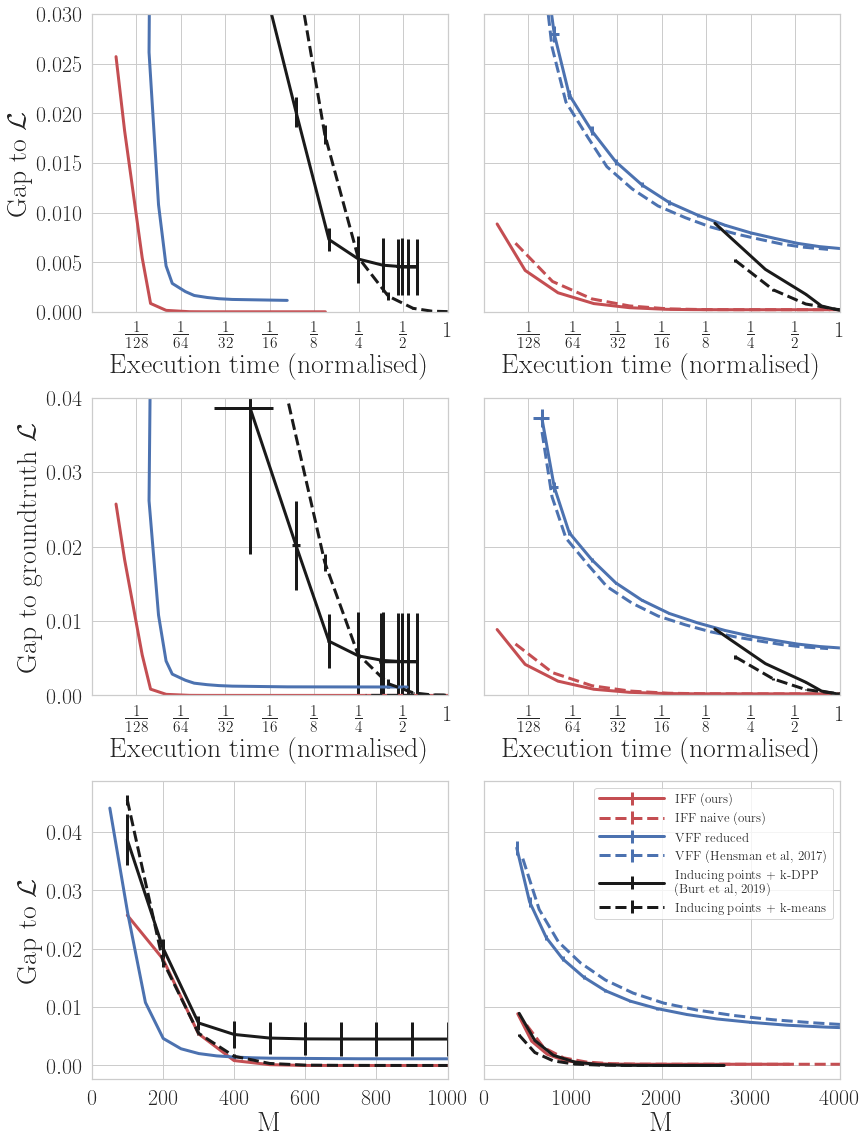

In [61]:
import matplotlib

fig, axs = plt.subplots(3, 2, sharey="row", figsize=(12, 16))

D=1

models = [
    'iff',
    'vff',
    'cv',
    'km',
]

results = {}
for model in models: # load the data
    f = open('./redux_{}_{}.json'.format(model, D))
    results[model] = json.load(f)
    
    results[model]['gap'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['gap'][1:]], axis=0)
    results[model]['kl'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['kl'][1:]], axis=0)
    results[model]['t'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['t'][1:]], axis=0)

means = {}
stds = {}
for model in models:
    means[model] = {}
    stds[model] = {}
    for key in ['gap', 'kl', 't']:
        means[model][key] = lab.mean(results[model][key], axis=0)
        stds[model][key] = lab.std(results[model][key], axis=0)/lab.sqrt(results[model][key].shape[0])
    
    
base_t = means['km']['t'][-4]
for model in models:
    means[model]['t'] = means[model]['t']/base_t
    stds[model]['t'] = stds[model]['t']/base_t
print(means['km']['t'])
# plot style for each method
styles = {
    'iff' : ('r', 'solid', 1),
    'vff' : ('b', 'solid', 1),
    'km' : ('k', 'dashed', 1.),
    'cv' : ('k', 'solid', 1.),
}

labels = {
    'iff' : 'IFF (ours)',
    'vff' : 'VFF (Hensman et al, 2017)',
    'km' : 'Inducing points + k-means',
    'cv' : 'Inducing points + k-DPP\n(Burt et al, 2019)',
    }

Ms = {
    'iff' : [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 3000],
    'vff' :  [25, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 751, 1501],
    'km' : [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'cv' :  [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

for model in models:
    if model == "km":
        end = -3
    else:
        end = -1
    axs[0][0].errorbar(x=means[model]['t'][1:end], y=means[model]['kl'][1:end], 
                 yerr=2*stds[model]['kl'][1:end], xerr=2*stds[model]['kl'][1:end], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[0][0].set_xlabel(r'Execution time (normalised)', weight='bold')
axs[0][0].set_ylabel(r'Gap to $\mathcal{L}$',  weight='bold')
#plt.legend(handlelength=5)
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}_kl_t.png'.format(D, N),  bbox_inches="tight")



for model in models:
    axs[1][0].errorbar(x=means[model]['t'][1:], y=means[model]['kl'][1:], 
                 yerr=2*stds[model]['gap'][1:], xerr=2*stds[model]['gap'][1:], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[1][0].set_xlabel(r'Execution time (normalised)', weight='bold')
axs[1][0].set_ylabel(r'Gap to groundtruth $\mathcal{L}$',  weight='bold')
#plt.legend()
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}_gap_t.png'.format(D, N),  bbox_inches="tight")


for model in models:
    axs[2][0].errorbar(x=Ms[model][1:], y=means[model]['kl'][1:], 
                 yerr=2*stds[model]['kl'][1:], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[2][0].set_xlabel(r'M', weight='bold')
axs[2][0].set_ylabel(r'Gap to $\mathcal{L}$',  weight='bold')
#plt.legend()
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}kl_M.png'.format(D, N),  bbox_inches="tight")

D=2

# Need eps, a, and b to recover the number of features in IFF and VFF
seed = 7
lab.set_random_seed(seed)

N = 10000
L = lab.ones(1)
D = 2
width = 5/(L)
sigma_f = 1.
snr = 0.774 # some arbitrary numeber
x = 6*width*lab.rand(N, D) -3*width
eps = .95/(6*width)
a = np.array([x.min()-0.05]*D)
b = np.array([x.max()+0.05]*D)

models = [
    'iff',
    'iff_naive',
    'vff',
    'vff_naive',
    'cv',
    'km',
]

results = {}
for model in models: # load the data
    f = open('./redux_{}_{}.json'.format(model, D))
    results[model] = json.load(f)
    
    results[model]['gap'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['gap'][1:]], axis=0)
    results[model]['kl'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['kl'][1:]], axis=0)
    results[model]['t'] = lab.concat(*[lab.expand_dims(np.array(a), axis=0) for a in results[model]['t'][1:]], axis=0)

means = {}
stds = {}
for model in models:
    means[model] = {}
    stds[model] = {}
    for key in ['gap', 'kl', 't']:
        means[model][key] = lab.mean(results[model][key], axis=0)
        stds[model][key] = lab.std(results[model][key], axis=0)/lab.sqrt(results[model][key].shape[0])
    
    
base_t = means['cv']['t'][5]
for model in models:
    means[model]['t'] = means[model]['t']/base_t
    stds[model]['t'] = stds[model]['t']/base_t

# plot style for each method
styles = {
    'iff' : ('r', 'solid', 1),
    'iff_naive' : ('r', 'dashed', 1),
    'vff' : ('b', 'solid', 1),
    'vff_naive' : ('b', 'dashed', 1),
    'km' : ('k', 'dashed', 1.),
    'cv' : ('k', 'solid', 1.),
}

labels = {
    'iff' : 'IFF (ours)',
    'iff_naive' : 'IFF naive (ours)',
    'vff' : 'VFF reduced',
    'vff_naive' : 'VFF (Hensman et al, 2017)',
    'km' : 'Inducing points + k-means',
    'cv' : 'Inducing points + k-DPP\n(Burt et al, 2019)',
    }

def get_number_of_iff_features(m):
    u = vff.inducing_variables.MaskedProductIFF(
            [vff.inducing_variables.IntegratedFourierFeature1D(eps, m//2) for d in range(D)]
        )
    return u.M

def get_number_of_vff_features(m, mask_type):
    u = vff.inducing_variables.VariationalFourierFeatureProduct(a=np.array(a), b=np.array(b), Md=m, D=D, 
                                                                    mask_type=mask_type)
    return u.M    
    
Ms = {
    'iff' : [get_number_of_iff_features(M) for M in [10, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66]],
    'iff_naive' : [M**D for M in [10, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66]],
    'vff' : [get_number_of_vff_features(M, "spherical_vff") for M in [5, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]],
    'vff_naive' : [get_number_of_vff_features(M, "none") for M in [5, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]],
    'km' : [M**D for M in [10, 20, 24, 28, 32, 36, 40, 44, 48, 52]],
    'cv' :  [M**D for M in [10, 20, 24, 28, 32, 36, 40, 44, 48, 52]],
}

for model in models:
    axs[0][1].errorbar(x=means[model]['t'][1:], y=means[model]['kl'][1:], 
                 yerr=2*stds[model]['kl'][1:], xerr=2*stds[model]['kl'][1:], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[0][1].set_xlabel(r'Execution time (normalised)', weight='bold')
#plt.legend(handlelength=5)
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}_kl_t.png'.format(D, N),  bbox_inches="tight")

for model in models:
    axs[1][1].errorbar(x=means[model]['t'][1:], y=means[model]['kl'][1:], 
                 yerr=2*stds[model]['gap'][1:], xerr=2*stds[model]['gap'][1:], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[1][1].set_xlabel(r'Execution time (normalised)', weight='bold')
#plt.legend()
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}_gap_t.png'.format(D, N),  bbox_inches="tight")


for model in models:
    axs[2][1].errorbar(x=Ms[model][1:], y=means[model]['kl'][1:], 
                 yerr=2*stds[model]['kl'][1:], label=labels[model], color=styles[model][0],
                                   linestyle = styles[model][1], alpha=styles[model][2])
axs[2][1].set_xlabel(r'M', weight='bold')
#plt.legend()
#plt.xlim(0.5, 5)
#plt.savefig('../images/D_{}_N_{}kl_M.png'.format(D, N),  bbox_inches="tight")

axs[2][1].legend(handlelength=5, loc="upper right", fontsize=13)


axs[2][0].set_xlim(0, 1000)
axs[2][1].set_xlim(0, 4000)
axs[0][0].set_xscale("log", base=2)
axs[1][0].set_xscale("log", base=2)
axs[0][1].set_xscale("log", base=2)
axs[1][1].set_xscale("log", base=2)
def format_func(n, tn):
    for i in range(8):
        if n == 1/(2**i):
            break
    if i == 0:
        return r"1"
    else:
        return r"$\frac{{1}}{{{}}}$".format(2**i)
        return r"$\frac{1}{2}$"
axs[0][0].xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.]))
axs[0][0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
axs[0][1].xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.]))
axs[0][1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
axs[1][0].xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.]))
axs[1][0].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
axs[1][1].xaxis.set_major_locator(matplotlib.ticker.FixedLocator([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.]))
axs[1][1].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
axs[1][0].set_xlim(2**(-8), 1.)
axs[1][1].set_xlim(2**(-8), 1.)
axs[0][0].set_xlim(2**(-8), 1.)
axs[0][1].set_xlim(2**(-8), 1.)


axs[0][0].set_ylim(0., 0.03)
axs[1][0].set_ylim(0., 0.04)


plt.tight_layout()


plt.savefig(f"../images/se_tableau.png", bbox_inches="tight")
plt.savefig(f"../images/se_tableau.svg", bbox_inches="tight")
plt.show()



